In [1]:
#라이브러리 로드
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
np.random.seed(42)
tf.set_random_seed(42)
sess = tf.Session()

iris = datasets.load_iris()

x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

In [3]:
#데이터 셋을 학습 셋과 테스트 셋으로 분할합니다.
#학습 셋, 테스트 셋 모두 정확도를 평가 할 것입니다.

#학습하기 위해 분할 한 데이터 셋
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace = False)

#테스트하기 위해 분할 한 데이터 셋
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

In [4]:
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]

y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [5]:
#일괄 작업 크기를 설정하고 플레이스 홀더, 모델 변수를 선언합니다.

#이 작업은 SVM 알고리즘 수렴에 도움이 되게 일괄 작업 크기를 크게 설정하였습니다.
#일괄 작업 크기가 작으면 최대 마진 직선이 조금씩 움직이게 되빈다.
#수렴이 진행됨에 따라서 학습률의 크기를 줄이는 것이 이상적이긴 하지만 현재로서는 이정도로 충분합니다.
batch_size = 100

x_data = tf.placeholder(shape = [None, 2], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

#꽃받침 길이와 꽃잎폭 두 가지 예상변수가 있기 때문에 변수는 A는 2x1 형태를 갖고 있습니다.
A = tf.Variable(tf.random_normal(shape = [2, 1]))
b = tf.Variable(tf.random_normal(shape = [1, 1]))

In [6]:
#모델 출력 값을 선언하는 부분입니다.
#잘 분류 된 경우에는 대상 값이 setosa일 떄는 1보다 크거나 같은 값이 출력됩니다.
#대상 값이 setosa가 아닐 경우 -1보다 작거나 같은 값이 출력 될 것입니다.

model_output = tf.subtract(tf.matmul(x_data, A), b)

In [7]:
#최대 마진 비용 함수에 필요한 구성 요소들을 선언하는 부분입니다.

#벡터의 l2노름을 계산하는 함수를 선언합니다.
l2_norm = tf.reduce_sum(tf.square(A))

#마진 매개변수 알파를 추가합니다.
alpha = tf.constant([0.01])

#두 항을 더하는 분류 비용 함수를 선언합니다
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf. multiply(model_output, y_target))))

loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

In [8]:
#학습 셋과 테스트 셋을 대상으로 정확도를 측정하기 위해 예측 함수와 정확도 함수를 선언합니다
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

In [9]:
#최적화 함수를 선언하고 모델 변수를 초기화 해줍니다.
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

init = tf.global_variables_initializer()

sess.run(init)

In [10]:
#학습 루프를 실행하는 부분입니다.
loss_vec = []
train_accuracy = []
test_accuracy = []

#학습 도중에 비용 함수 값과 더불어 학습 셋과 테스트 셋 양쪽의 정확도를 기록합니다.
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)

    train_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_train,
        y_target: np.transpose([y_vals_train])})
    train_accuracy.append(train_acc_temp)

    test_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_test,
        y_target: np.transpose([y_vals_test])})
    test_accuracy.append(test_acc_temp)

    if (i + 1) % 100 == 0:
        print('Step #{} A = {}, b = {}'.format(
            str(i+1),
            str(sess.run(A)),
            str(sess.run(b))
        ))
        print('Loss = ' + str(temp_loss))

Step #100 A = [[ 0.38866633]
 [-2.6225927 ]], b = [[0.18244827]]
Loss = [0.11478747]
Step #200 A = [[ 0.39312914]
 [-2.6143656 ]], b = [[0.17334823]]
Loss = [0.10606352]
Step #300 A = [[ 0.3908235]
 [-2.607217 ]], b = [[0.1650482]]
Loss = [0.11641035]
Step #400 A = [[ 0.38602635]
 [-2.601627  ]], b = [[0.15714815]]
Loss = [0.08565885]
Step #500 A = [[ 0.3884642]
 [-2.5951316]], b = [[0.14774813]]
Loss = [0.10671981]


In [11]:
#결과를 그림으로 나타내기 위해서 계수를 추출하는 작업입니다.

#요인 추출을 하기 위한 작업입니다.
[[a1], [a2]] = sess.run(A)
[[b]] = sess.run(b)

slope = -a2/a1

y_intercept = b/a1

#x1과 x2값 추출
x1_vals = [d[1] for d in x_vals]

#최적화가 된 선을 얻기 위한 작업입니다.
best_fit = []

for i in x1_vals:
    best_fit.append(slope*i+y_intercept)

#I와 setosa로 분류하는 작업
setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == 1]
setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == 1]

not_setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == -1]
not_setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == -1]

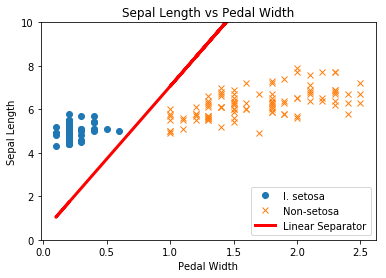

In [12]:
#선현 구분자 및 정확도, 비용 함수를 그래프로 나타내는 작업입니다.
%matplotlib inline

#두 분류에 대한 선형 SVM 최적화 최종 결과 그래프
plt.plot(setosa_x, setosa_y, 'o', label='I. setosa')
plt.plot(not_setosa_x, not_setosa_y, 'x', label='Non-setosa')
plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

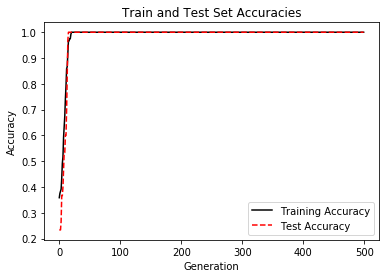

In [13]:
#학습 진행 중인 모델의 테스트 셋 및 학습 셋에 대한 정확도를 출력합니다.
#두 분류가 선형적으로 구분 가능하기 때문에 정확도는 100%에 도달하게 됩니다.
plt.plot(train_accuracy, 'k-', label='Training Accuracy')
plt.plot(test_accuracy, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

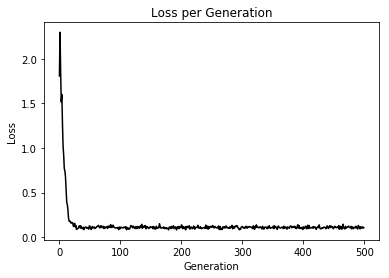

In [14]:
#500회 학습 과정 중의 최대 마진 비용 함수 값을 그래프로 표현하는 과정입니다.
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()